In [1]:
from matplotlib import pyplot as plt
import turbine_data as turbine
import xfoil_scripts as xfoil
from tqdm import tqdm
import numpy as np
#np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)   
import os
import timeit
import sys
import pickle
alpha,_,_,_ = turbine.get_ClCd_from_file()
import torch

##### Old dataset [UNUSED]

In [2]:
def load_all_data():
    data = []
    for f in range(30):
        x,y = turbine.get_xy_from_file(f)
        alpha,Cl,Cd = turbine.get_ClCd_from_file(f)
        
        for a in range(len(alpha)):
            input = [x,y,alpha[a]]
            target = [Cl[a],Cd[a]]
            data.append([input,target])
            
    return data

##### Move coordinates to xfoil-compatible plain format

In [3]:
def write_coordinates_to_plain_file():
    for k in range(30):
        x,y = turbine.get_xy_from_file(k)
        pairs = [[x[i],y[i]] for i in range(len(x))]
        #pairs = [pairs[i+99] if i <= 100 else pairs[199-i] for i in range(200)]
        with open("plaincoordinates_IEA_10_198_RWT/AF"+str(k).rjust(2).replace(" ","0")+".txt","w") as f:
            for pair in pairs:
                (x,y) = pair
                f.write(str(x))
                f.write("  ")
                f.write(str(y))
                f.write("\n")

In [4]:
write_coordinates_to_plain_file()

FileNotFoundError: [Errno 2] No such file or directory: 'plaincoordinates_IEA_10_198_RWT/AF00.txt'

##### xfoil data generation

In [ ]:
def run_xfoil_on_everything(data):
    os.system("taskkill /im xfoil.exe /F")
    mach = turbine.get_speed(Mach=True)
    pbar_desc = "Airfoil {}: {} complete ({} timeouts and {} nonconvergence)"
    pbar = tqdm(total=30*100)

    for airfoil in range(0,30):
        alpha, Cl, Cd, Cm = turbine.get_ClCd_from_file(airfoil)
        errors = np.zeros_like(alpha)
        succeeded = 0
        nonconvergence = 0
        out_of_time = 0
        timeout = 0.5 if airfoil<=5 else 1
        
        for a in range(50,150):
            try:
                res = xfoil.run_xfoil(Re=1e7,Mach=mach[airfoil],alpha=alpha[a],
                                        iter=500,airfoil=airfoil,timeout=timeout)
                # Add xfoil results
                data[airfoil, "xfoil", alpha[a], "Cl"] = res["CL"]
                data[airfoil, "xfoil", alpha[a], "Cd"] = res["CD"]
                data[airfoil, "xfoil", alpha[a], "Cm"] = res["CM"]
                
                # Error handling etc            
                succeeded += 1
            except TimeoutError:
                errors[a] = 1
                out_of_time += 1
            except ValueError:
                errors[a] = 1
                nonconvergence += 1
            pbar.update(1)
            pbar.set_description(pbar_desc.format(airfoil,a-49,out_of_time,nonconvergence))    

##### Add Target Data

In [6]:
def add_target_data(data):
    for airfoil in range(30):
        alpha, Cl, Cd, Cm = turbine.get_ClCd_from_file(airfoil)
        for a in range(0,200):
            data[airfoil, "Target", alpha[a], "Cl"] = Cl[a]
            data[airfoil, "Target", alpha[a], "Cd"] = Cd[a]
            data[airfoil, "Target", alpha[a], "Cm"] = Cm[a]

##### Simple interpolation of missing values

In [7]:
def interpolate_results(data, airfoil=20,source="xfoil",type="Cl",method="nearest",deg=3):
    alpha,_,_,_ = turbine.get_ClCd_from_file(airfoil)
    for a in range(50,150):
        if (c:=(airfoil,source,alpha[a],type)) not in data:
            local_mean = 0
            basis = 0
            if method=="mean":
                for m in range(np.maximum(a-deg,0), np.minimum(a+deg+1,len(alpha))):
                    if (tup:=(airfoil,source,alpha[m],type)) in data:
                        local_mean += data[tup]
                        basis += 1
                if (margin:=np.minimum(a-50,150-a)) < deg:
                    crit = deg - (deg-margin)/2
                else:
                    crit = deg
                if basis>=(crit):
                    data[c] = local_mean/basis
                else:
                    raise ValueError("Missing too many. Foil {}, alpha {}".format(airfoil,alpha[a]))
            if method=="nearest":
                neighbours = {}
                # Find nearest below:
                k = a
                while (k:=k-1)>=(a-deg) and "below" not in neighbours:
                    if (tup:=(airfoil,source,alpha[k],type)) in data:
                        neighbours["below"] = data[tup]
                k = a
                while (k:=k+1)<=(a+deg) and "above" not in neighbours:
                    if (tup:=(airfoil,source,alpha[k],type)) in data:
                        neighbours["above"] = data[tup]
                
                if ("above" in neighbours) and ("below" in neighbours):
                    data[c] = (neighbours["above"]+neighbours["below"])/2
                elif ("above" in neighbours):
                    data[c] = neighbours["above"]
                elif ("below" in neighbours):
                    data[c] = neighbours["below"]
                else:
                    raise ValueError("No neighbour.")
            
def interpolate_missing_xfoil_datapoints(d):
    for airfoil in range(6,30):
        interpolate_results(d,airfoil,"xfoil","Cl")
        interpolate_results(d,airfoil,"xfoil","Cd")
        interpolate_results(d,airfoil,"xfoil","Cm")

Add the shape and additional blade geometry-related data to the dataset.

In [8]:
def add_blade_shape_data(data):
    speed_info = turbine.get_speed(Mach=True)
    blade_info = turbine.get_blade_data()

    for foil in range(30):

        data[foil, "MachSpeed"] = speed_info[foil]
        data[foil, "PositionOnWing"] = blade_info["BladeSpan"][foil]
        data[foil, "OutOfPlaneOffset"] = blade_info["BladeCurvature"][foil]
        data[foil, "InPlaneOffset"] = blade_info["BladeSweep"][foil]
        data[foil, "CurvatureAngle"] = blade_info["BladeCurvatureAngle"][foil]
        data[foil, "TwistAngle"] = blade_info["BladeTwistAngle"][foil]
        data[foil, "ChordLength"] = blade_info["BladeChordLength"][foil]
    
    for foil in range(30):

        x,y = turbine.get_xy_from_file(airfoil=foil)
        rx,ry = turbine.get_reduced_resolution_shape(airfoil=foil,resolution=0.1)

        data[foil, "ShapeX"] = x
        data[foil, "ShapeY"] = y
        data[foil, "ReducedX"] = rx
        data[foil, "ReducedY"] = ry

##### Process data

In [9]:
#with open("dataset/dataset.pickle","rb") as f:
#    data = pickle.load(f)

In [10]:
# with open("dataset/RawData.pickle","rb") as f: d = pickle.load(f)
# print("Dataset is "+str(round(sys.getsizeof(d)/1e6,2))+" MB with "+str(len(d))+" entries.")

In [11]:
# interpolate_missing_xfoil_datapoints(d)
# add_blade_shape_data(d)
# add_target_data(d)
# print("Dataset is "+str(round(sys.getsizeof(d)/1e6,2))+" MB with "+str(len(d))+" entries.")

In [12]:
#with open("readable.txt","w") as f:
#    for key,value in data.items():
#        print((str(key)+":").ljust(42)+str(value),file=f)

In [13]:
#with open("dataset.pickle","wb") as f:
#    pickle.dump(data,f)

##### Plot reduced resolution shapes

In [14]:
# plt.rcParams["figure.figsize"] = [2,60]
# fig,ax = plt.subplots(30,sharex=True)
# for i in range(30):
#     x,y = turbine.get_reduced_resolution_shape(i)
#     ax[i].scatter(x,y)
#     ax[i].set_xlim((0,1))
#     ax[i].set_ylim((-0.5,0.5))

In [15]:
with open("dataset/dataset.pickle","rb") as f: data = pickle.load(f)

##### Compare Interpolation Results

Blue points mark interpolated values (nearest neighbour).
Cl <----------------------------------------------------> Cd


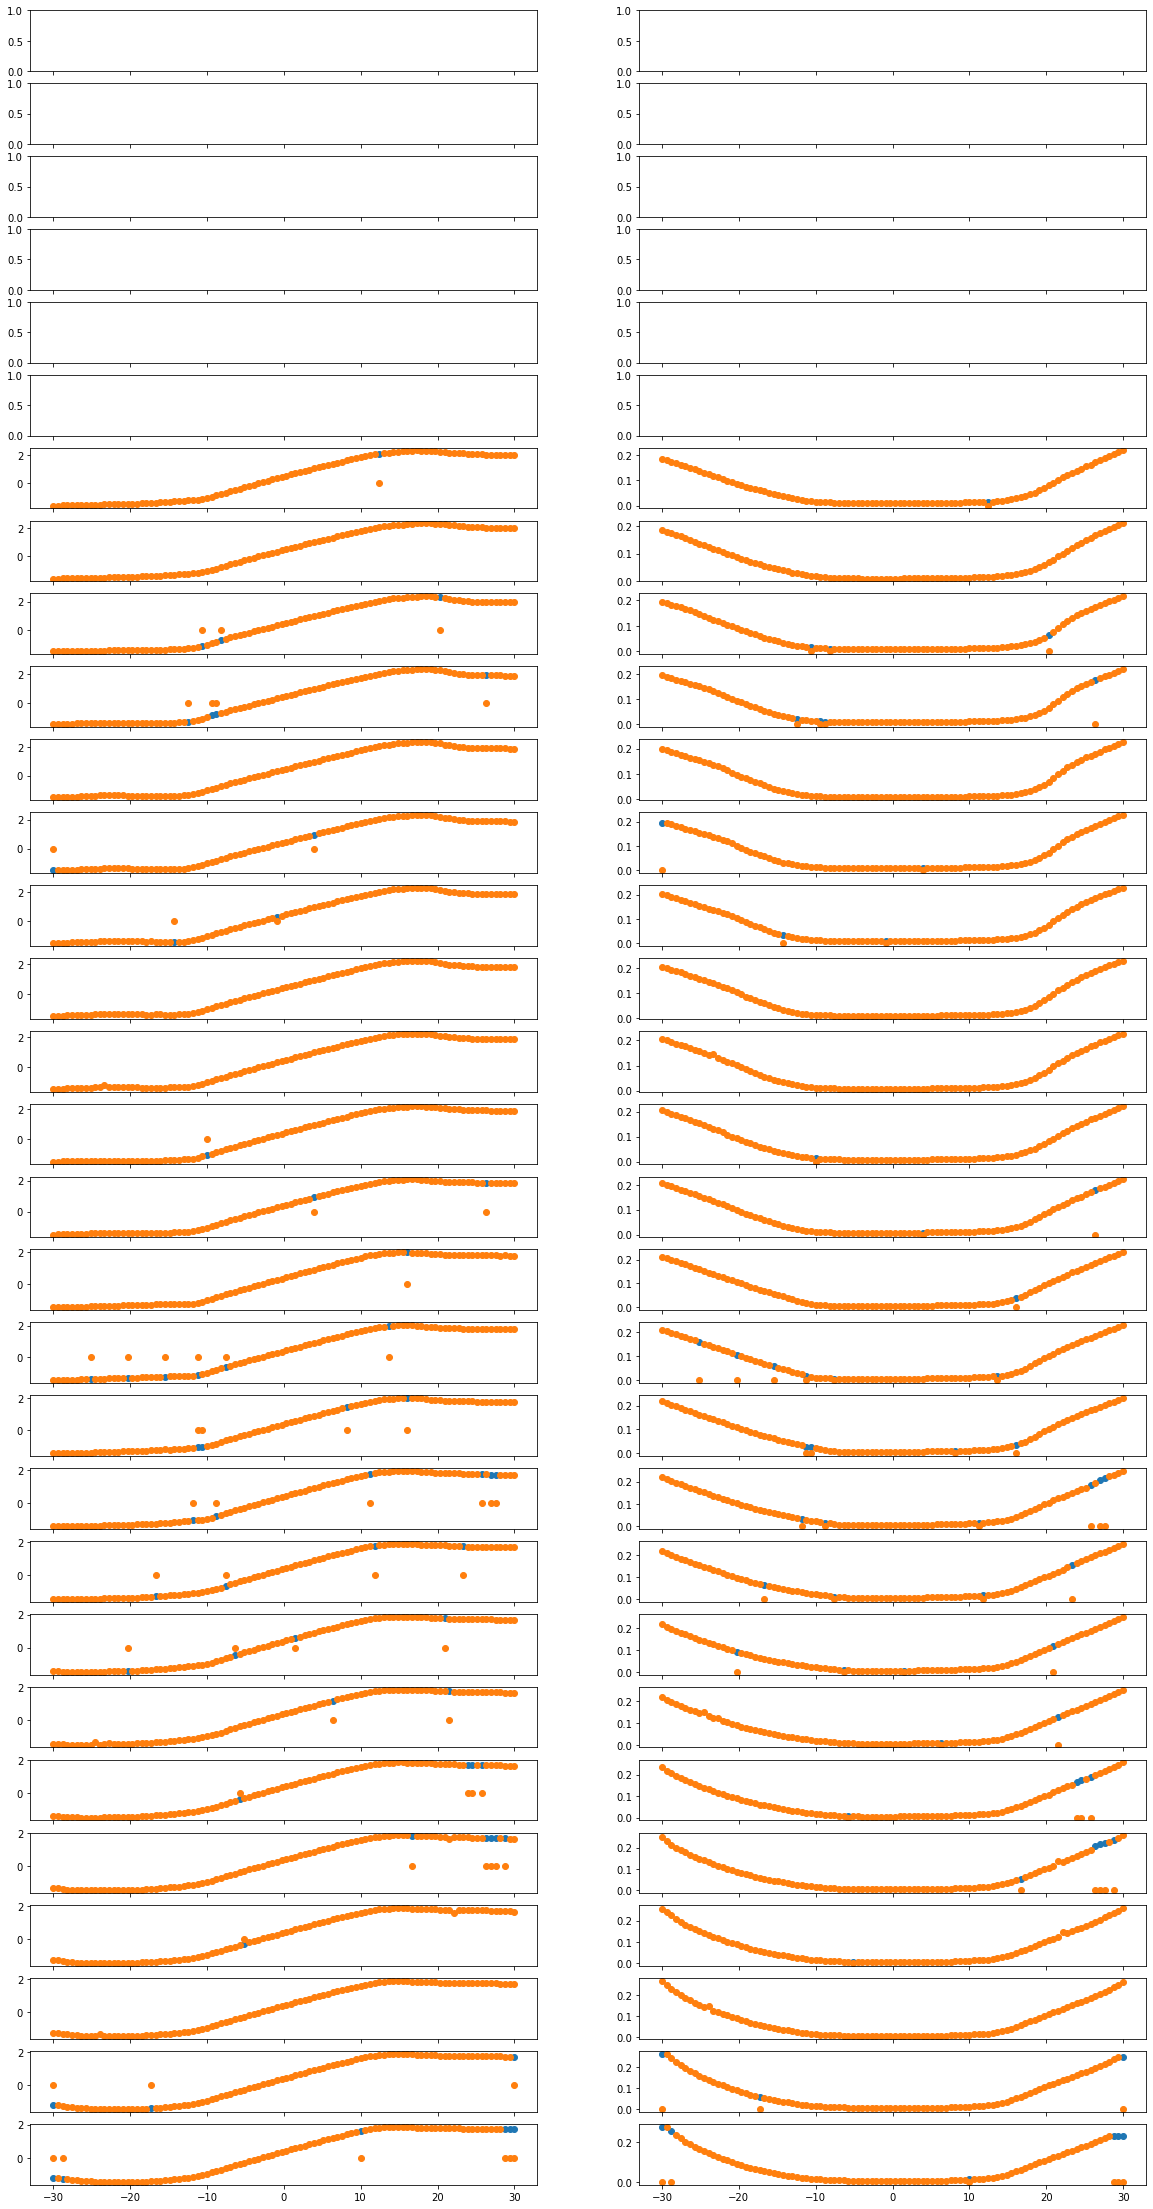

In [20]:
with open("dataset/RawData.pickle","rb") as f:    d_raw = pickle.load(f)
with open("dataset/dataset.pickle","rb") as f:    d = pickle.load(f)
measure = "Cl"
plt.rcParams['figure.figsize'] = [20,40]
al = alpha[50:150]
print("Blue points mark interpolated values (nearest neighbour).")
print("Cl <----------------------------------------------------> Cd")
fig,ax = plt.subplots(30,2,sharex=True)
for f in range(0,30):
    try:
        da = [d[tup] if (tup:=(f,"xfoil",a,measure)) not in d_raw else np.nan for a in al]
        db = [d_raw[tup] if (tup:=(f,"xfoil",a,measure)) in d_raw else 0 for a in al]
        ax[f][0].scatter(al,da)
        ax[f][0].scatter(al,db)
        da = [d[tup] if (tup:=(f,"xfoil",a,"Cd")) not in d_raw else np.nan for a in al]
        db = [d_raw[tup] if (tup:=(f,"xfoil",a,"Cd")) in d_raw else 0 for a in al]
        ax[f][1].scatter(al,da)
        ax[f][1].scatter(al,db)
    except:
        pass

Single graph.

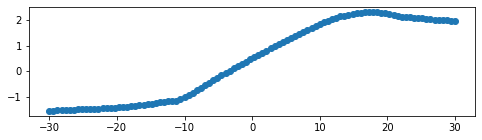

In [39]:
airfoil = 6
value = "Cl"
source = "xfoil"
plt.rcParams['figure.figsize'] = [8,2]
da = [d[key] if (key:=(airfoil,source,a,value)) in d else np.nan for a in alpha[50:150]]
plt.scatter(alpha[50:150],da)

### Normalized Dataset

In [2]:
alpha,_,_,_ = turbine.get_ClCd_from_file(0)

In [3]:
with open("dataset/dataset.pickle","rb") as f:
    data = pickle.load(f)

In [4]:
values = []
for foil in range(6,30):
    for a in alpha[50:150]:
        try: 
            values.append(data[foil,'xfoil',a,'Cl'][0])
            values.append(data[foil,'xfoil',a,'Cd'][0])
            values.append(data[foil,'xfoil',a,'Cm'][0])
        except:
            pass
lo = min(values)
hi = max(values)
for foil in range(6,30):
    for a in alpha[50:150]:
        data[foil,'xfoil',a,'Cl'] = [2*(data[foil,'xfoil',a,'Cl'][0]-lo)/(hi-lo)-1]
        data[foil,'xfoil',a,'Cd'] = [2*(data[foil,'xfoil',a,'Cd'][0]-lo)/(hi-lo)-1]
        data[foil,'xfoil',a,'Cm'] = [2*(data[foil,'xfoil',a,'Cm'][0]-lo)/(hi-lo)-1]

In [5]:
lo

-1.5716

In [6]:
hi

2.3858

In [10]:
d = []
for f in range(6,30):
    for a in alpha[50:150]:
        d.append(data[f,'xfoil',a,'Cl'])
d = np.array(d)
d.mean()

-0.04479008734691128

In [16]:
try:
    os.remove("dataset/normalizedcoefficients.pickle")
except FileNotFoundError:
    print("File already removed.")

File already removed.


In [17]:
with open("dataset/normalizedcoefficients.pickle","wb") as f:
    pickle.dump(data,f)

In [18]:
with open("dataset/normalized_readable.txt","w") as f:
   for key,value in data.items():
       print((str(key)+":").ljust(42)+str(value),file=f)

# Tensored Dataset

In [3]:
with open("dataset/normalized.pickle","rb") as f:
    data = pickle.load(f)

In [4]:
aots,_,_,_ = turbine.get_ClCd_from_file(0)
keys = [(foil,a) for foil in range(30) for a in aots]

tensordata = {}

for k in range(len(keys)):
    (foil,alpha) = keys[k]

    if foil<6 or alpha<-30 or alpha>30:
        xfoil_support = False
        re = -1
    else:
        re = 0
        xfoil_support = True
    
    al = (alpha+180)/360
    
    target = torch.tensor([ data[(foil,"Target",alpha,"Cl")],
                            data[(foil,"Target",alpha,"Cd")],
                            data[(foil,"Target",alpha,"Cm")]]).float()

    if xfoil_support:
        input = [True,      # whether physics support is available or not
                    torch.cat(( torch.tensor(data[(foil,"ReducedX")]).float(), # the shape of the airfoil
                                torch.tensor(data[(foil,"ReducedY")]).float())),
                    torch.tensor([  data[(foil,"xfoil",alpha,"Cl")][0],    # supporting values
                                    data[(foil,"xfoil",alpha,"Cd")][0],
                                    data[(foil,"xfoil",alpha,"Cm")][0],
                                re, al]).float()]
    elif xfoil_support==False:
        input = [False,      # whether physics support is available or not
                    torch.cat(( torch.tensor(data[(foil,"ReducedX")]).float(), # the shape of the airfoil
                                torch.tensor(data[(foil,"ReducedY")]).float())),
                    torch.tensor([0,0,0,re,al]).float()] # supporting values

    tensordata[foil,alpha] = (input,target)

In [5]:
with open("dataset/small_modification.pickle","wb") as f:
    pickle.dump(tensordata,f)

In [15]:
with open("dataset/tensored_readable.txt","w") as f:
   for key,value in tensordata.items():
       print((str(key)+":").ljust(30)+str(value),file=f)

In [2]:
from dataset import AirfoilDataset
import timeit
import torch
from network import NetworkModule

In [2]:
d = AirfoilDataset()

In [12]:
%timeit d[10]

1.72 µs ± 208 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [7]:
old = AirfoilDataset(dataset_type="old")

In [26]:
training_airfoils = [5,13,21,25]
validation_airfoils = [9]
testing_airfoils = [17]

In [27]:
net = NetworkModule(architecture='l6_i3',
                    train_airfoils = training_airfoils,
                    val_airfoils=validation_airfoils,
                    test_airfoils=testing_airfoils,
                    batch_size = 8,
                    learning_rate = 0.01)